# To-Dos

In [1]:
## Outlier Removal
## Time zone is Data Pull
## Cumulative Logic

# Import Packages

In [1]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [3]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'rJava'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      rJava 
       TRUE

In [4]:
options(scipen = 999)

# Import Data

In [267]:
## 2019-01-07 -- Chase DL Errors
df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdl_2019-1-25_1505.csv')

## 2018-11-01 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdl_2019-1-25_1200.csv')

## 2018-12-25 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdl_2019-1-25_1147.csv')

# 2019-01-01 -- Complete DL Outage
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexport_2019-1-25_1115.csv')

## 2019-01-11 -- Friday with Wells Fargo DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexport_2019-1-25_0949.csv')

## 2019-01-12 -- Saturday with Wells Fargo DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexport_2019-1-24_1444.csv')




df$hist_q = ifelse(is.na(df$hist_q) == TRUE, 0, df$hist_q)
df$hist_dl = ifelse(is.na(df$hist_dl) == TRUE, 0, df$hist_dl)
df$q = ifelse(is.na(df$q) == TRUE, 0, df$q)
df$dl = ifelse(is.na(df$dl) == TRUE, 0, df$dl)

head(df)

dayofyear,dayofweek,hourofday,hist_q,hist_dl,timestart,q,dl
2018-10-07,0,0,26,8,,0,0
2018-10-07,0,1,16,5,,0,0
2018-10-07,0,2,18,4,,0,0
2018-10-07,0,3,12,5,,0,0
2018-10-07,0,4,5,1,,0,0
2018-10-07,0,5,12,7,,0,0


# Clean the data

### Get Information on the "Session_Date"

In [268]:
getSessionInfo = function() {

    current.date = max(
        as.Date(
            df$timestart[which(df$q != 0)], 
            format = "%Y-%m-%d %H:%M:%S"
        )
    )

    current.day = unique(
        df$dayofweek[which(df$q != 0)]
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

str(getSessionInfo())

List of 3
 $ date : Date[1:1], format: "2019-01-07"
 $ dow  : int 1
 $ hours: num [1:24] 0 1 2 3 4 5 6 7 8 9 ...


### Get Aggregated Data for the "Session_Date" (Test)

In [269]:
getSessionDataCumulative = function() {
    
    df.session = unique(df[ ,which(colnames(df) %in% c('dayofweek','hourofday','q','dl'))])
    # nrow(df.replicate) #168

    session.point.estimates = 
        df.session[which(df.session$dayofweek == getSessionInfo()$dow), ] %>%
        group_by(
            dayofweek
        ) %>%
        mutate(
#             hourofday = hourofday,
            q.session.cum = cumsum(q),
            dl.session.cum = cumsum(dl),
            ratio.session.cum = ifelse(
                cumsum(q) > 0,
                cumsum(dl)/cumsum(q),
                0
            )
        )
#         summarize(
#             dl.session = sum(dl),
#             q.session = sum(q),
#             ratio.session = ifelse(
#                 sum(q) > 0,
#                 sum(dl)/sum(q),
#                 0
#             )
#         )
    
#     session.point.estimates$dl.session = cumsum(session.point.estimates$dl.session)
#     session.point.estimates$q.session = cumsum(session.point.estimates$q.session)
#     session.point.estimates$ratio.session = session.point.estimates$dl.session/session.point.estimates$q.session
    
    return(session.point.estimates)
}

str(getSessionDataCumulative())
getSessionDataCumulative()

Classes 'grouped_df', 'tbl_df', 'tbl' and 'data.frame':	24 obs. of  7 variables:
 $ dayofweek        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ hourofday        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ q                : num  54 40 34 18 14 40 49 105 160 198 ...
 $ dl               : num  18 21 11 6 7 19 18 50 69 97 ...
 $ q.session.cum    : num  54 94 128 146 160 200 249 354 514 712 ...
 $ dl.session.cum   : num  18 39 50 56 63 82 100 150 219 316 ...
 $ ratio.session.cum: num  0.333 0.415 0.391 0.384 0.394 ...
 - attr(*, "vars")= chr "dayofweek"
 - attr(*, "labels")='data.frame':	1 obs. of  1 variable:
  ..$ dayofweek: int 1
  ..- attr(*, "vars")= chr "dayofweek"
  ..- attr(*, "drop")= logi TRUE
 - attr(*, "indices")=List of 1
  ..$ : int  0 1 2 3 4 5 6 7 8 9 ...
 - attr(*, "drop")= logi TRUE
 - attr(*, "group_sizes")= int 24
 - attr(*, "biggest_group_size")= int 24


dayofweek,hourofday,q,dl,q.session.cum,dl.session.cum,ratio.session.cum
1,0,54,18,54,18,0.3333333
1,1,40,21,94,39,0.4148936
1,2,34,11,128,50,0.3906250
1,3,18,6,146,56,0.3835616
1,4,14,7,160,63,0.3937500
1,5,40,19,200,82,0.4100000
1,6,49,18,249,100,0.4016064
1,7,105,50,354,150,0.4237288
1,8,160,69,514,219,0.4260700
1,9,198,97,712,316,0.4438202


### Get Aggregated Data for History (Training)

In [270]:
df.hist = df[ ,which(colnames(df) %in% c('dayofyear','dayofweek','hourofday','hist_q','hist_dl'))]
    
df.hist.mutate = 
    df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
    group_by(
        dayofyear
    ) %>%
    mutate(
#         dayofweek = dayofweek,
#         hourofday = hourofday,
        q.hist.cum = cumsum(hist_q),
        dl.hist.cum = cumsum(hist_dl)
    )
str(data.frame(df.hist.mutate))
head(data.frame(df.hist.mutate))

'data.frame':	312 obs. of  7 variables:
 $ dayofyear  : Factor w/ 92 levels "2018-10-07","2018-10-08",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ dayofweek  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ hourofday  : int  0 1 2 3 4 5 6 7 8 9 ...
 $ hist_q     : int  17 20 19 10 11 27 35 78 105 172 ...
 $ hist_dl    : num  7 8 4 2 4 10 19 30 44 64 ...
 $ q.hist.cum : int  17 37 56 66 77 104 139 217 322 494 ...
 $ dl.hist.cum: num  7 15 19 21 25 35 54 84 128 192 ...


dayofyear,dayofweek,hourofday,hist_q,hist_dl,q.hist.cum,dl.hist.cum
2018-10-08,1,0,17,7,17,7
2018-10-08,1,1,20,8,37,15
2018-10-08,1,2,19,4,56,19
2018-10-08,1,3,10,2,66,21
2018-10-08,1,4,11,4,77,25
2018-10-08,1,5,27,10,104,35


In [271]:
getHistoricalDataCumulative = function() {

    df.hist = df[ ,which(colnames(df) %in% c('dayofyear','dayofweek','hourofday','hist_q','hist_dl'))]
    
    df.hist.mutate = data.frame(
        df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
        group_by(
            dayofyear
        ) %>%
        transmute(
            dayofweek = dayofweek,
            hourofday = hourofday,
            dl.hist.cum = cumsum(hist_dl),
            q.hist.cum = cumsum(hist_q)
        )    
    )

    historical.point.estimates = 
#         df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
        df.hist.mutate %>%
        group_by(
            hourofday
        ) %>%
        summarize(
            dl.hist.cums = sum(dl.hist.cum),
            q.hist.cums = sum(q.hist.cum),
            r.hist.cums = sum(dl.hist.cum)/sum(q.hist.cum),
            n.hist.cums = sum(q.hist.cum),
            sd.q.hist.cums = sd(q.hist.cum),
            sd.dl.hist.cums = sd(dl.hist.cum),
            mu.q.hist.cums = mean(q.hist.cum),
            corr.hist.cums = cor(q.hist.cum, dl.hist.cum),
            se.hist.cums = sqrt(
                (
                    (
                        sd(dl.hist.cum)^2 + 
                        sd(q.hist.cum)^2 * (sum(dl.hist.cum)/sum(q.hist.cum))^2 -
                        2 * sum(dl.hist.cum)/sum(q.hist.cum) * cor(q.hist.cum, dl.hist.cum) * sd(dl.hist.cum) * sd(q.hist.cum)
                    ) /
                    (
                        sum(q.hist.cum) *
                        mean(q.hist.cum)^2
                    )
                )
            ),
            n()
        )

    return(historical.point.estimates)
}

str(getHistoricalDataCumulative())
# rbind(head(getHistoricalData(),3), tail(getHistoricalData(),3))
getHistoricalDataCumulative()

Classes 'tbl_df', 'tbl' and 'data.frame':	24 obs. of  11 variables:
 $ hourofday      : int  0 1 2 3 4 5 6 7 8 9 ...
 $ dl.hist.cums   : num  185 329 422 508 621 ...
 $ q.hist.cums    : int  434 787 1083 1315 1605 2066 2794 4167 6158 8649 ...
 $ r.hist.cums    : num  0.426 0.418 0.39 0.386 0.387 ...
 $ n.hist.cums    : int  434 787 1083 1315 1605 2066 2794 4167 6158 8649 ...
 $ sd.q.hist.cums : num  10.2 15.3 18.6 21.2 27.7 ...
 $ sd.dl.hist.cums: num  6 9.43 9.6 11.02 11.67 ...
 $ mu.q.hist.cums : num  33.4 60.5 83.3 101.2 123.5 ...
 $ corr.hist.cums : num  0.68 0.813 0.761 0.74 0.814 ...
 $ se.hist.cums   : num  0.00634 0.00332 0.00227 0.00202 0.00139 ...
 $ n()            : int  13 13 13 13 13 13 13 13 13 13 ...


hourofday,dl.hist.cums,q.hist.cums,r.hist.cums,n.hist.cums,sd.q.hist.cums,sd.dl.hist.cums,mu.q.hist.cums,corr.hist.cums,se.hist.cums,n()
0,185,434,0.4262673,434,10.20244,6.002136,33.38462,0.6802136,0.0063375377,13
1,329,787,0.4180432,787,15.28951,9.428544,60.53846,0.8132556,0.0033168065,13
2,422,1083,0.3896584,1083,18.57141,9.597008,83.30769,0.7612606,0.0022700600,13
3,508,1315,0.3863118,1315,21.20867,11.018632,101.15385,0.7398838,0.0020208438,13
4,621,1605,0.3869159,1605,27.65446,11.670146,123.46154,0.8142433,0.0013909416,13
5,805,2066,0.3896418,2066,36.48164,14.453728,158.92308,0.8398075,0.0011236528,13
6,1162,2794,0.4158912,2794,50.68113,20.369661,214.92308,0.8797328,0.0008967041,13
7,1861,4167,0.4466043,4167,74.05698,32.434154,320.53846,0.9090061,0.0006759742,13
8,2938,6158,0.4771030,6158,112.36131,53.221236,473.69231,0.9401186,0.0004973896,13
9,4243,8649,0.4905769,8649,154.60831,79.318491,665.30769,0.9095532,0.0005361106,13


# Run the bootstrap

### Construct Data Frame to store final information for ggplot.

In [272]:
df.session = getSessionDataCumulative()
df.historical = getHistoricalDataCumulative()

ci.information = data.frame(
    
    hour.session = df.session$hourofday,
    r.session = df.session$ratio.session.cum,
    r.hist = df.historical$r.hist.cums,
    se.hist = df.historical$se.hist.cums,
    z_lower = rep(0,24),
    z_upper = rep(0,24),
    ci.lower = rep(0,24),
    ci.upper = rep(0,24)
)

ci.information

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.3333333,0.4262673,0.0063375377,0,0,0,0
1,0.4148936,0.4180432,0.0033168065,0,0,0,0
2,0.3906250,0.3896584,0.0022700600,0,0,0,0
3,0.3835616,0.3863118,0.0020208438,0,0,0,0
4,0.3937500,0.3869159,0.0013909416,0,0,0,0
5,0.4100000,0.3896418,0.0011236528,0,0,0,0
6,0.4016064,0.4158912,0.0008967041,0,0,0,0
7,0.4237288,0.4466043,0.0006759742,0,0,0,0
8,0.4260700,0.4771030,0.0004973896,0,0,0,0
9,0.4438202,0.4905769,0.0005361106,0,0,0,0


### Execute the Bootstrap.

In [258]:
## Set parametres and intialize.
B = 5000
bootstrap_z = vector(length = B)
alpha = 1/20

start_time = Sys.time()


## Subset the data to the DOW in question.
df.training.dow = df.hist.mutate


for (i in 1:24) {
    
    for (j in 1:B) {
      
      
    
        ## Subset the data to the current HOD (i).
        df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]
    
        index = seq(
            1, 
            nrow(df.training.dow.hour)
        )
        resample_index = sample(
            x = index, 
            size = length(index), 
            replace = TRUE
        )
        df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]
      
    
        ## Calculate statistics from the resample.
        r = sum(df.training.dow.hour.resample$dl.hist.cum)/sum(df.training.dow.hour.resample$q.hist.cum)
        n = sum(df.training.dow.hour.resample$q.hist.cum)
        sx = sd(df.training.dow.hour.resample$q.hist.cum)
        sy = sd(df.training.dow.hour.resample$dl.hist.cum)
        mx = mean(df.training.dow.hour.resample$q.hist.cum)
        corr = cor(df.training.dow.hour.resample$dl.hist.cum, df.training.dow.hour.resample$q.hist.cum)
      
        se = sqrt(
            (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
            (n*mx^2)
        )
      
      
        ## Calculate statistics from the training data.
        mu = ci.information$r.hist[i]
      
      
        ## Calculate the bootstrap Z
        bootstrap_z[j] = (r - mu)/se
    }
    
    
    ## For each hour, take Percentiles of the Bootstrap Z vector to caluclate the confidence interval for that hour.
    bootstrap_z = sort(bootstrap_z)
    
    ci.information$z_lower[i] = bootstrap_z[alpha/2*B]
    ci.information$z_upper[i] = bootstrap_z[(1-alpha/2)*B]
    
    ci.information$ci.lower = ci.information$r.hist - ci.information$z_upper * ci.information$se.hist
    ci.information$ci.upper = ci.information$r.hist - ci.information$z_lower * ci.information$se.hist
}

elapsed_time = Sys.time() - start_time
elapsed_time

ci.information

Time difference of 2.655683 mins

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.0000000,0.6087786,0.0119273855,-15.86698,11.75900,0.4685245,0.7980302
1,0.0000000,1.0021858,0.0153978120,-20.43057,17.94883,0.7258131,1.3167718
2,0.0000000,1.3917197,0.0140241430,-21.56774,21.52365,1.0898690,1.6941888
3,0.0000000,1.8308870,0.0143802236,-23.76428,26.19070,1.4542589,2.1726226
4,0.0000000,2.2054583,0.0134543705,-25.55161,29.63502,1.8067377,2.5492392
5,0.0000000,2.3943257,0.0099007054,-28.94307,29.75526,2.0997276,2.6808825
6,0.0000000,2.2358865,0.0063017819,-36.18537,33.67984,2.0236434,2.4639188
7,0.0000000,1.8551282,0.0037426850,-46.30849,40.11213,1.7050012,2.0284463
8,0.0000000,1.5293937,0.0022340605,-47.77510,52.21769,1.4127362,1.6361262
9,0.2909091,1.2764606,0.0013952721,-59.34544,62.51918,1.1892293,1.3592636


### Adjust morning hours of high variance (negative CI.Lower)

In [264]:
ci.information.bounded = ci.information

morning.start = 1
morning.end = 11

ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)] = max(c(ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)],0.05))



ci.information.bounded$ci.lower = ifelse(
    ci.information.bounded$hour.session >= morning.start & ci.information.bounded$hour.session <= morning.end,
    (
        # y = mx + b
        (ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.end + 1)] - ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)]) / 12 * ci.information.bounded$hour.session +
        ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)] +

        # jitter
        runif(
            n = 1,
            min = 0,
            max = 0.005
        ) * (morning.end + 1 - ci.information.bounded$hour.session) * (morning.start - 1 - ci.information.bounded$hour.session)
    ),
    ci.information.bounded$ci.lower
)
ci.information.bounded

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.0000000,0.6087786,0.0119273855,-15.86698,11.75900,0.4685245,0.7980302
1,0.0000000,1.0021858,0.0153978120,-20.43057,17.94883,0.4498164,1.3167718
2,0.0000000,1.3917197,0.0140241430,-21.56774,21.52365,0.4395099,1.6941888
3,0.0000000,1.8308870,0.0143802236,-23.76428,26.19070,0.4376051,2.1726226
4,0.0000000,2.2054583,0.0134543705,-25.55161,29.63502,0.4441020,2.5492392
5,0.0000000,2.3943257,0.0099007054,-28.94307,29.75526,0.4590007,2.6808825
6,0.0000000,2.2358865,0.0063017819,-36.18537,33.67984,0.4823009,2.4639188
7,0.0000000,1.8551282,0.0037426850,-46.30849,40.11213,0.5140029,2.0284463
8,0.0000000,1.5293937,0.0022340605,-47.77510,52.21769,0.5541066,1.6361262
9,0.2909091,1.2764606,0.0013952721,-59.34544,62.51918,0.6026120,1.3592636


### Smooth the CI.Lower Line

In [265]:
ci.information.smooth = ci.information.bounded

smoothing.iterations = 4

for (i in 1:smoothing.iterations) {
    
    for (j in (0+1):(23-1)) {

        ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)] = mean(
            c(ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)-1], ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)+1])
        )
    }        
}

ci.information.smooth

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.0000000,0.6087786,0.0119273855,-15.86698,11.75900,0.4685245,0.7980302
1,0.0000000,1.0021858,0.0153978120,-20.43057,17.94883,0.4620907,1.3167718
2,0.0000000,1.3917197,0.0140241430,-21.56774,21.52365,0.4597921,1.6941888
3,0.0000000,1.8308870,0.0143802236,-23.76428,26.19070,0.4630071,2.1726226
4,0.0000000,2.2054583,0.0134543705,-25.55161,29.63502,0.4727203,2.5492392
5,0.0000000,2.3943257,0.0099007054,-28.94307,29.75526,0.4896086,2.6808825
6,0.0000000,2.2358865,0.0063017819,-36.18537,33.67984,0.5141232,2.4639188
7,0.0000000,1.8551282,0.0037426850,-46.30849,40.11213,0.5465574,2.0284463
8,0.0000000,1.5293937,0.0022340605,-47.77510,52.21769,0.5870980,1.6361262
9,0.2909091,1.2764606,0.0013952721,-59.34544,62.51918,0.6271908,1.3592636


# Create the ggplot

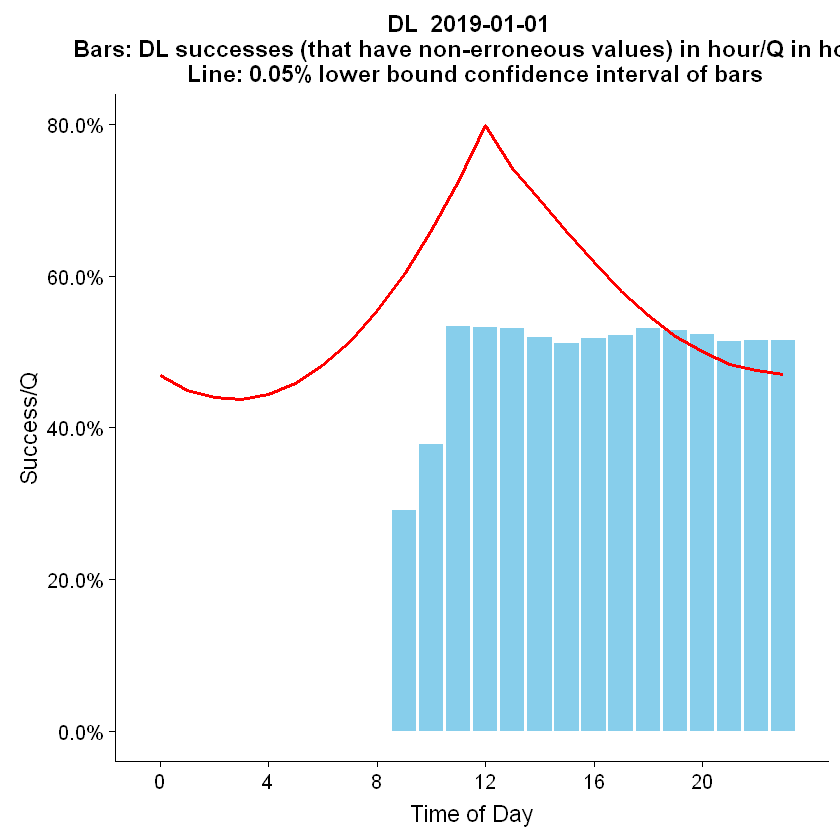

In [266]:
ggplot(
#     data = ci.information.smooth,
    data = ci.information.bounded,
#     data = ci.information, 
    mapping = aes(
        x = hour.session, 
        y = r.session
    )
) +
geom_col(
    fill = 'sky blue'
) + 
labs(
    x ="Time of Day", 
    y = "Success/Q", 
    title = paste(
        "DL ", getSessionInfo()$date,
        "\n", "Bars: DL successes (that have non-erroneous values) in hour/Q in hour", 
        "\n", "Line: 0.05% lower bound confidence interval of bars")
) + 
geom_line(
    aes(
        x = hour.session, 
        y = ci.lower
    ), 
    color = 'red', 
    size=1
) + 
# geom_line(
#     aes(
#         x = hour.session, 
#         y = ci.upper
#     ), 
#     color = 'blue', 
#     size=1
# ) + 
scale_y_continuous(
    labels = scales::percent 
) + 
scale_x_continuous(
    breaks = seq(0,23,4)
)# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
